# Albero ricoprente di costo minimo capacitato

Il problema CMST è un'estensione del MST (minimum spanning tree). Un problema che mi chiede di trovare quale struttura
garantisca la connessione fra tutti i nodi con il costo minore. Qui considero un solo flusso d'informazioni (o merci),
cioè single commodity. In generale queste informazioni scorrono su link di capacità finita da un nodo radice a dei nodi
foglia che agiscono da "sink" delle informazioni, i consumatori. 
Il problema più spesso risolto nella pratica è quello del MST; dal quale deriviamo il protocollo di rete STP (spanning tree
protocol) di livello link-local (ISO/OSI layer 2). Questa invece è una versione constrained (capacitata) MST.
La formulazione proposta in questo progetto va in una direzione diversa,
sappiamo che nel caso in cui ci sia un server centrale che spinge informazioni lungo la rete il limite di capacità dei link è ricavabile con un probelma di flusso massimo (risolvibile con ad esempio l'algoritmo di Ford&Fulkerson).
* Che dire del caso in cui io abbia decine di nodi collegati al server centrale tramite una dorsale, come valuto la resilienza di una tale rete?
* Come posso garantire che il minor numero di utenti si scolleghi dalla rete nel caso in cui la dorsale si interrompa?
* Per quale tipo di metrica è meglio ottimizzare, la posa in opera dell'infrastruttura o la latenza sulla linea?
* Che dire della ridondanza della rete?

Queste sono solo alcune delle domande che posso includere nel modello come "criteri" guida decisionali. Nel caso in
esame prendo solo in considerazione le prime due domande della lista. 
    
    Vorrei limitare il numero di nodi che sono collegati alla radice attraverso un singolo collegamento (dorsale).

Un primo modo per risolvere è avere un albero "bilanciato", cioè con un numero di nodi circa uguale in ogni ramo della radice. Questo garantisce che, per esempio, se su $ N $ collegamenti uscenti dalla radice se ne interrompesse uno, avrei $ \frac{1}{N} $ utenti scollegati rispetto al totale. Lo stesso ragionamento lo posso ripetere ricorsivamente per ogni sottoalbero che si diparte dalla sorgente. Ciò che vorrei è limitare il numero massimo di utenti serviti da un certo collegamento, in modo da limitare il numero di utenti scollegati in caso di guasti su quello specifico collegamento.

## Formulazione del problema
Una rete di telecomunicazioni può essere modellata da un grafo $ G = (N, A) $ con $ N $ insieme dei nodi che nel nostro
studio rappresenta un cliente che si connette alla rete (telecomunicazioni, gas, in generale è una rete di flusso ). L'
insieme $ A $ è l'insieme degli archi che sono attivi e che collegano i nodi nel grafo, nel nostro caso rappresentano linee
attive ed utilizzabili. Impostiamo il seguente programma:

$$ Min \sum_{(i,j) \in A}\ c_{ij} x_{ij} \ $$
$$ \sum_{(j,i) \in A}\ x_{ij} -  \sum_{(i,j) \in A}\ x_{ij} = b_j	 \quad \forall i \in N \qquad (1) \ $$
$$ \sum_{(i,j) \in A}\ y_{ij}  	\leq 1 \quad \forall j \in N 	\setminus{i} \qquad (2) \ $$
$$ \sum_{(i,j) \in S}\ x_{ij}  	\leq |S| - 1 \quad \forall S \in N  \qquad (3) \ $$
$$ x_{ij} \leq  Qy_{ij}  	 \quad \forall (i,j)  \in A \qquad (4)	\ $$
$$ y_{ij} \in \{ 0,1 \}  	 \quad \forall (i,j)  \in A \qquad (5)	\ $$
$$ x_{ij} \geq 0 	 \quad \forall (i,j)  \in A 	\qquad (6) \ $$

$ y_{ij} $ sono le variabili decisionali (creo un collegamento fra $ i $ e $ j $)

$ x_{ij} $ sono le variabili di flusso

Questa variante single commodity del problema MST capacitato può essere modificata per accomodare altri tipi di flusso
i quali non devono mescolarsi o che devono essere in generale sempre distinguibili (eg. traffico di controllo e traffico
utenti) ottenendo la variante multicommodity.

#### Descrizione dei vincoli
* Il vincolo $ (1) $ è il vincolo di conservazione del flusso, che garantisce che ogni utente venga soddisfatto con la sua
richiesta di pacchetti e che i pacchetti non vengano creati o distrutti dal nulla.
* Il vincolo $ (2) $ è il vincolo che mi permette di selezionare un solo arco entrante nel generico nodo $ i-esimo $
* Il vincolo $ (4) $ è il vincolo di linking. Questo è il vincolo complicante, infatti se $ y_{ij} = 0 $ allora non scorre niente; invece se $ y_{ij} = 1 $ il flusso potrebbe non avere più limiti perché posso porre $ Q \to \infty $ (o comunque un big-M). Nel mio caso invece pongo $ Q = n $ con $ n $ un numero opportuno, un upper bound sul numero di nodi serviti da un certo arco. Questo upper bound sarà tanto più stringente quanto più il ramo è vicino alla radice (più sono in alto e più traffico trasporto).
* Il vincolo $ (3) $ è il vincolo di subtour elimination, ogni sottoinsieme di $ k $ nodi deve avere al massimo $ k-1 $ archi. Questo potrebbe essere sostituito da i vincoli di Miller-Tucker-Zemlin che sono in numero polinomiale.

### Complessità
Questo problema a causa dei vincoli di linking è in complessità esponenziale. Questi vincoli legano le variabili
decisionali con quelle di flusso. 
Un primo tentativo potrebbe essere quello fatto con un rilassamento continuo della variabile binaria $ y_{ij} $.
Questo però, porterebbe a snaturare il vincolo logico ottenendo $ y_{ij} \geq  \frac{x_{ij}}{Q}$ che per $ Q \to \infty $
che diverrebbe  $ y_{ij} \geq 0 $ e cioè un vincolo inutile. 
Oppure posso tentare di rafforzare la formulazione prendendo un $ Q $p leggermente sopra la capacità massima (dunque non un big-M) e sottraendo la richiesta $ b_j $. Attenzione, è possibile costruire un piccolo esempio che dimostra come questo porta a sottostimare i costi della rete. Costruirsi un rilassamento adeguato non è banale, dunque la prima soluzione euristica che ha dato dei risultati "accettabili" è quella dell'algoritmo genetico di seguito descritto.

### Ipotesi operative
Ora proseguo con le ipotesi operative:
1. La locazione di ogni nodo è già fornita
2. I nodi sono perfettamente affidabili
3. Ogni collegamento è bidirezionale
4. Non ci sono collegamenti ridondanti
5. I collegamenti sono attivi o rotti
6. I fallimenti sono indipendenti fra loro
7. Non vengono esaminate riparazioni
8. La capacità $ Q $ è fissata ad un valore intero

## Algoritmo genetico
<img src="flowchart.png" align="left"> La procedura per questa meta-euristica è abbastanza standard con i seguenti passi:

### Descrizione algoritmo
1. Inizializzazione

In [1]:
from __future__ import division
import random
from CMST_package.hall_of_fame import Hof
from CMST_package.individual import Individual
import sys
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

ADJACENCY_MATRIX = []         # Struttura dati di appoggio del grafo
INDEX_RANGE = 256 
MINIMIZE = True               # È un MINIMUM spanning tree...
MAXIMUM_FITNESS = 1000        # Valore di convenienza di un cromosoma "inutile"
POP_SIZE = 100                # Dimensione della popolazione
GRAPH_FILE = 16               # Numero di nodi nel grafo
CROSS_MUTATE_PROB = .7        # Probabilità di mutazione nell'accopiamento
SELF_MUTATE_PROB = .2         # Probabiltà di mutazione (distr. uniforme)
NUMB_GENER = 300              # Iterazioni nel loop evolutivo
HOF_SIZE = 3                  # Hall of Fame (quanti sono i migliori mai visti)
TOURNAMENT_SIZE = 20          # Numero di partacipanti alla selezione
NUM_NODES = int(GRAPH_FILE)
ROOT = 4 # random.randint(1, NUM_NODES) # Chi è la radice
CAPACITY = 4                  # Capacità Q (vedi vincolo 3 formulazione)
TREE_LIKE_LAYOUT = 1
MESH_LIKE_LAYOUT = 0
PLANAR_LAYOUT = 4
SPECTRAL_LAYOUT = 3

2. Creare una popolazione iniziale

In [2]:
def generate_population(num_individuals, ind_size):
    """
    Crea una lista vuota, poi trasformala in una lista di individui che a loro volta saranno delle strutture dati vuote
    ma così ho una lista di "contenitori" del mio individuo.
    Vedi il file Individual.py
    :param num_individuals:
    :param ind_size:
    :return generated_pop: Lista di individui vuoti che serviranno come contenitori
    """
    generated_pop = list()
    for _ in range(num_individuals):
        generated_pop.append(
            Individual(ind_size, MINIMIZE, INDEX_RANGE))
    return generated_pop

3. Calcolare la fitness (questo lo posso anche parallelizzare), attenzione necessito di una funzione per contare i nodi
in un ramo

In [3]:
def measure_branch(tree, parent, prev):
    """
    Questa funzione mi conta i nodi in un certo sotto albero (o ramo), mi serve per capire quanti nodi sto servendo con
    questo collegamento. Viene usata nella funzione che calcola la fitness, in base a quanti nodi ci sono valuto se sto
    violando la capacità.
    """
    weight = 0
    for edge in tree:
        if edge[0] == parent and edge[1] != prev:
            weight += measure_branch(tree, edge[1], parent)
        elif edge[0] != prev and edge[1] == parent:
            weight += measure_branch(tree, edge[0], parent)
    return weight + 1


def fitness_evaluation(individuals):

    global NUM_NODES
    for ind in individuals:
        # Estrai l'individuo sotto esame e crea una nuova matrice
        genome = ind.genotype
        
        # Crea una matrice dei costi per la rappresentazione
        # matrix è usa e getta
        matrix = [[sys.maxsize for x in range(NUM_NODES)] 
                  for x in range(NUM_NODES)]
        
        # Vedi appunti Cappanera dove creo una matrice equivalente
        # altrimenti sovrascrivi quella buona
        for col in range(len(matrix)):
            for row in range(len(matrix[col])):
                if row != col:
                    L = max(row, col)
                    S = min(row, col)
                    index = L * (L - 1) / 2
                    index += S - 1
                    index -= L
                    index += NUM_NODES
                    matrix[col][row] = genome[row]
                    matrix[col][row] += genome[col]
                    matrix[col][row] += genome[int(index)]

        # #####################DEBUG###################
        #
        # for col in range(len(matrix)):
        #     for row in range(len(matrix[col])):
        #         print('{:3}'.format(matrix[col][row]), end=" ")
        #     print()
        # print()
        # #####################DEBUG###################

        # Prim così ottengo il MST classico
        tree = prim(matrix)

        # Depth first search a partire dal nodo ROOT
        over_capacity = False
        for edge in tree:
            temp_weight = 0
            if edge[0] == ROOT:
                temp_weight = measure_branch(tree, edge[1], ROOT)
            elif edge[1] == ROOT:
                temp_weight = measure_branch(tree, edge[0], ROOT)
            if temp_weight > CAPACITY:
                ind.tree = tree
                ind.fitness = MAXIMUM_FITNESS
                over_capacity = True

        # Prendi il peso della rappresentazione equivalente 
        # sei sotto la capacità, cioè seleziona quelli ammissibili
        # sotto il vincolo di capacità
        if not over_capacity:
            weight = 0
            for edge in tree:
                (col, row) = edge
                weight += ADJACENCY_MATRIX[col - 1][row - 1]
            ind.tree = tree
            ind.fitness = weight

4. Questa è la funzione che mi permette di lavorare con alberi ricoprenti ```prim(matrix):```

In [4]:
def prim(matrix):
    nodes = [1]
    tree = []
    while len(tree) < NUM_NODES - 1:
        poss_edges = {}
        minimum = sys.maxsize
        for col in nodes:
            for row in range(len(matrix[col - 1])):
                if not row + 1 in nodes:
                    poss_edges[(col, row + 1)] = matrix[col - 1][row]
        smallest = ((0, 0), sys.maxsize)
        for edge, weight in poss_edges.items():
            if weight < smallest[1]:   # Condizione di ottimalità
                smallest = (edge, weight)
        # Aggiungi ramo
        tree.append(smallest[0])
        nodes.append(smallest[0][1])
    return tree

5. Effettuo la selezione degli individui migliori. Riporto nuovamente il frammento di codice per chiarezza con ulteriori commenti
```python
        over_capacity = False       # Parto con un albero (o soluzione/membro della popolazione) che ipotizzo
                                    # sia con un peso cumulativo degli archi dentro i limiti di capacità
        for edge in tree:           # Prendo un singolo candidato/albero e valuto il soddisfacimento dei vincoli di capacità
            b_weight = 0
            if edge[0] == ROOT:     # Inizio la misurazione del peso cumulativo "measure_branch" in modalità Breadth First
                b_weight = measure_branch(tree, edge[1], ROOT)
            elif edge[1] == ROOT:
                b_weight = measure_branch(tree, edge[0], ROOT)
            if b_weight > CAPACITY:
                ind.tree = tree
                ind.fitness = MAXIMUM_FITNESS # Non appena l'albero o un sottoalbero sfora la capacità assegnagli MAX_FITNESS
                over_capacity = True        # Non appena l'albero o un sottoalbero sfora la capacità setta il flag

        # Se questo albero (individuo) non ha sforato in nessun suo sottoramo il vincolo di capacità
        if not over_capacity:
            weight = 0
            for edge in tree:
                (col, row) = edge
                weight += ADJACENCY_MATRIX[col - 1][row - 1]    # Calcolati il peso cumulativo dei rami di questo spanning tree

            ind.tree = tree                                     # che non ha violato i vincoli e assegnalo all'individuo in modo
            ind.fitness = weight                                # da confrontarlo con le altre migliori soluzioni, nel modulo HOF
```

6. Effettuo mutazioni/crossover, cioè accoppiamento in cui combino i cromosomi dei genitori dando vita a due discendenti. Poi con questi dicendenti li rimetto nella popolazione totale (insieme ai genitori) e faccio la selezione con il Tournament Style.

In [5]:
def breeding_mutation(individuals, breeding_mutation_pb):
    individuals_pool_1 = list()
    individuals_pool_2 = list()

    # Selezione Tournament style, estraggo e tolgo gli "inadatti"
    mating_group = list()
    while len(mating_group) < len(individuals):
        best = None
        for i in range(TOURNAMENT_SIZE):
            ind = individuals[random.randint(0, len(individuals) - 1)]
            if best is None or ind.fitness > best.fitness: # Scegli il fittest
                best = ind
        mating_group.append(best)    # Qui aggiungo i migliori alla lista
    
    #Qui ho il gruppo che è "riuscito a riprodursi" -> mating_group 
    while mating_group:
        # Estrai ed aggiungi uno per uno altrimenti python rompe
        individuals_pool_1.append(mating_group.pop())
        individuals_pool_2.append(mating_group.pop())

    ret = list()  #Struttura di appoggio che poi restituirò indietro
    for i in range(len(individuals_pool_1)):
        individual_1 = individuals_pool_1.pop()
        individual_2 = individuals_pool_2.pop()
        if random.random() < breeding_mutation_pb:  # Mutazione probabilistica
            for i in range(random.randint(1, len(individual_1))):
                temp = individual_1[i]
                individual_1[i] = individual_2[i]   # Scambio di cromosomi
                individual_2[i] = temp              # era meglio usare swap()
        ret.append(individual_1)                    # nuovi figli mutati 
        ret.append(individual_2)                    # mettili nella lista che
    return ret                                      # poi restituisci

7. Introduco una mutazione casuale su un discendente singolo (self-mutation)

In [6]:
def self_mutation(individuals, mutation_pb):
    for Individual in individuals:
        for value in Individual:
            if random.random() < mutation_pb:
                value = random.randrange(0, INDEX_RANGE)
    return individuals

8. Genero i dati con una matrice di adiacenza casuale (è più semplice per visualizzare il tutto e soprattutto per testare con più istanze diverse fra loro)

In [7]:
def random_adjacency_matrix(matrix):
    """
    Funzione che crea una matrice di adiacenza aleatoria per la simulazione dell'algoritmo.
    Questa sezione è necessaria per testare come si comporta l'algoritmo al variare del grafo, dei
    pesi o degli archi cioè di chi collego o no.

    QUI IL SEED È PREFISSATO, NON È REALMENTE ALEATORIO, SE LO SI VUOLE ALEATORIO, TOGLIERE IL SEED
    #TODO: la firma è simil-C e fa schifo, restituisci la matrice
    :param matrix: matrice in cui appoggiare i risultati
    :return: matrice del grafo su cui si lavora (da implementare il return)
    """
    global MAXIMUM_FITNESS
    global ADJACENCY_MATRIX
    ADJACENCY_MATRIX = [[0 for x in range(NUM_NODES)] for x in range(NUM_NODES)]
    for col in range(len(ADJACENCY_MATRIX)):
        for row in range(col, len(ADJACENCY_MATRIX[col])):
            if col != row:
                # Peso dell'arco, aleatorio
                value = random.randint(0, 100)
            else:
                # Sulla diagonale ci metto +inf perché non so come dirgli 
                # il nodo sé stesso non ci mettere l'arco col peso...
                value = sys.maxsize
            # Archi simmetrici, cioè questo è un grafo NON diretto
            ADJACENCY_MATRIX[col][row] = value
            ADJACENCY_MATRIX[row][col] = value

            if row != col:
                if value > MAXIMUM_FITNESS:
                    MAXIMUM_FITNESS = value
                print('{:3}'.format(ADJACENCY_MATRIX[col][row]), end=" ")
                matrix[col][row] = ADJACENCY_MATRIX[col][row]
        print()

9. Funzione per visualizzare il grafo (o gli alberi soluzione finale)

In [8]:
def draw_graph(g, layout=MESH_LIKE_LAYOUT):
    """
    Funzione per la visualizzazione del grafo, questa usa Networkx per il disegno
        1. Faccio una conversione da lista generica (mia rappresentazione precedente) in grafo
        2. Setto i parametri che voglio nel disegno
        3. Disegno gli archi con le loro etichette
        4. Disegno i nodi
        5. Espongo il plot
    :param g: grafo da visualizzare
    :param layout: tipo di layout che si vuole (concentrico oppure gerarchico)
    :return:
    """
    if layout == 1:
        pos = nx.spring_layout(g)
    elif layout == 0:
        pos = nx.circular_layout(g)
    elif layout == 3:
        pos = nx.kamada_kawai_layout(g)
    else:
        pos = nx.planar_layout(g)
    # nodes
    nx.draw_networkx_nodes(g, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(g, pos, width=1)
    arc_weight = nx.get_edge_attributes(g, 'weight')

    nx.draw_networkx_edge_labels(g, pos, edge_labels=arc_weight)

    # labels
    nx.draw_networkx_labels(g, pos, font_size=20, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Risultati

Adesso lancio l'algoritmo generando la matrice di adianceza con pesi causali.

 69  94  52  76  32   7  73  75  37  73  39  92  79  72  73 
 63  14  34  92  99  99  83  22  98  58  30  70  50  67 
 81  46  16  29  81  24  91  82  21  62  78  62  19 
  4  28  65  34  26  23  99  66  27  94  91  19 
 26   7  13  94  69   9  63  21  82 100  67 
 77  92  36 100  23  45  58  50  79  42 
 50  75  39  76  34  63  67  70  44 
 80  62  75  49  91   5  22  60 
 28  84  24   5  56  28  59 
 32  31  41   7   7  92 
 52  44  59  94  48 
  5  15   5   5 
 30  69  34 
 71  55 
 41 



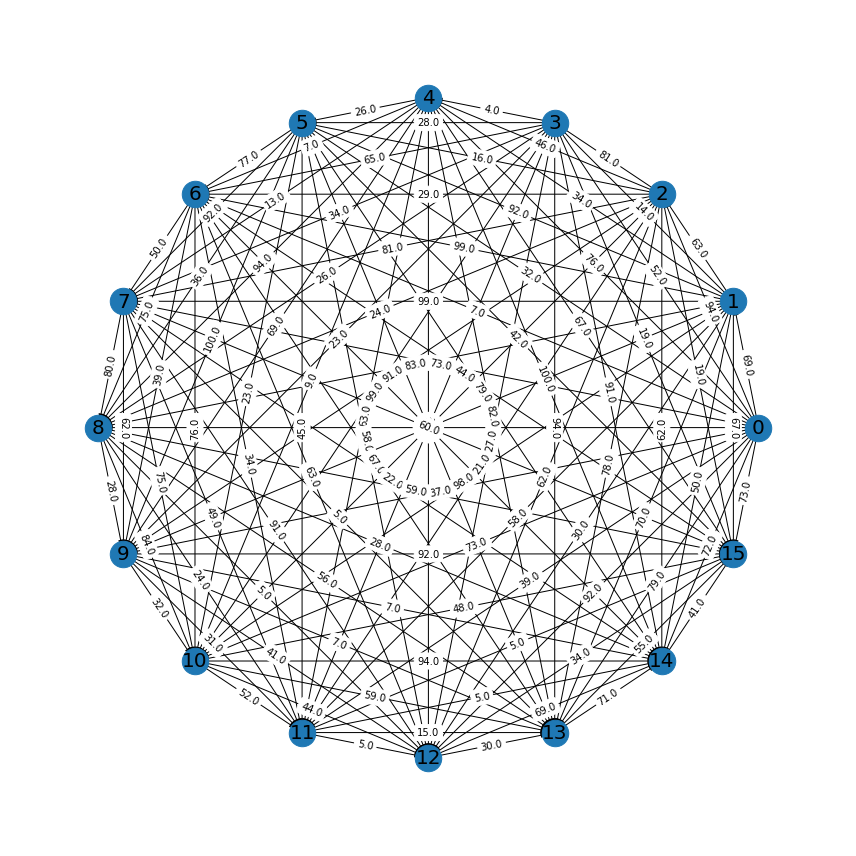

In [9]:
    # if __name__ == "__main__":
    
    Mat = np.zeros((NUM_NODES, NUM_NODES))
    random_adjacency_matrix(Mat)
    g = nx.from_numpy_matrix(Mat, create_using=nx.DiGraph)
    plt.figure(figsize=(12, 12))
    draw_graph(g, MESH_LIKE_LAYOUT)

Procedo con l'inizializzazione delle varie strutture dati.

In [10]:
    hall_of_fame = Hof(HOF_SIZE)

Memorizzo i migliori risultati parziali in modo da implementare una selezione elitarista a fine del ciclo evolutivo. Di seguito genero la popolazione inziale a partire dalla quale accoppio e muto generando nuovi discendenti. 

In [11]:
    population = generate_population(POP_SIZE + (POP_SIZE % 2), int(NUM_NODES * (NUM_NODES + 1) / 2))

Poiché la ```population``` è in pratica una lista che ho generato con pesi causali, devo valutarne la fitness (anche se è la popolazione iniziale devo comunque valutarne la 'fitness'), questo lo faccio tramite la funzione ```fitness_evaluation(individuals) ``` la quale si calcola e modifica la fitness di ogni elemento della popolazione in base al peso del suo spanning tree. Se il peso della spanning tree è minore della capacità allora lascio la sua fitness invariata, se invece è maggiore della capacità allora gli metto la MAX_FITNESS e verrà escluso dalla hall of fame.

In [12]:
    fitness_evaluation(population)
    hall_of_fame.update(population)

In seguito si parte con la generazione vera e propria cioè il loop evolutivo. Genero discendenti e questi li sottopongo a mutazione per accoppiamento e mutazione singola. Qui bisogna aspettare qualche secondo...

In [13]:
start = time.process_time()
#Loop generativo
for cur_gen in range(NUMB_GENER):
    new_chromosome = breeding_mutation(population, CROSS_MUTATE_PROB) # Qui appendo 2 nuovi membri alla vecchia popolazione
    genome = self_mutation(new_chromosome, SELF_MUTATE_PROB) # Qui muto la nuova popolazione in modo "singolo"
    fitness_evaluation(genome)    # Qui mi calcolo lo spanning tree associato a questa nuova popolazione 
    hall_of_fame.update(genome)   # Scelgo i 3 migliori spanning tree aggiornando se trovo qualcosa di meglio

Visualizzazione dei risultati

Fitness: 532
Tree: [(1, 10), (10, 4), (4, 2), (4, 16), (16, 13), (4, 8), (4, 5), (1, 11), (4, 6), (16, 3), (8, 14), (4, 15), (4, 7), (10, 9), (2, 12)]

Fitness: 614
Tree: [(1, 4), (4, 16), (4, 15), (4, 8), (4, 9), (4, 7), (4, 14), (15, 12), (9, 11), (7, 13), (4, 2), (4, 6), (15, 10), (16, 3), (8, 5)]

Fitness: 632
Tree: [(1, 4), (4, 12), (4, 9), (4, 16), (4, 10), (10, 7), (1, 11), (12, 5), (9, 14), (16, 2), (4, 15), (14, 8), (4, 6), (12, 13), (16, 3)]


Time:  15.84375
ROOT:  4
CAPACITY:  4
[(1, 10), (10, 4), (4, 2), (4, 16), (16, 13), (4, 8), (4, 5), (1, 11), (4, 6), (16, 3), (8, 14), (4, 15), (4, 7), (10, 9), (2, 12)]


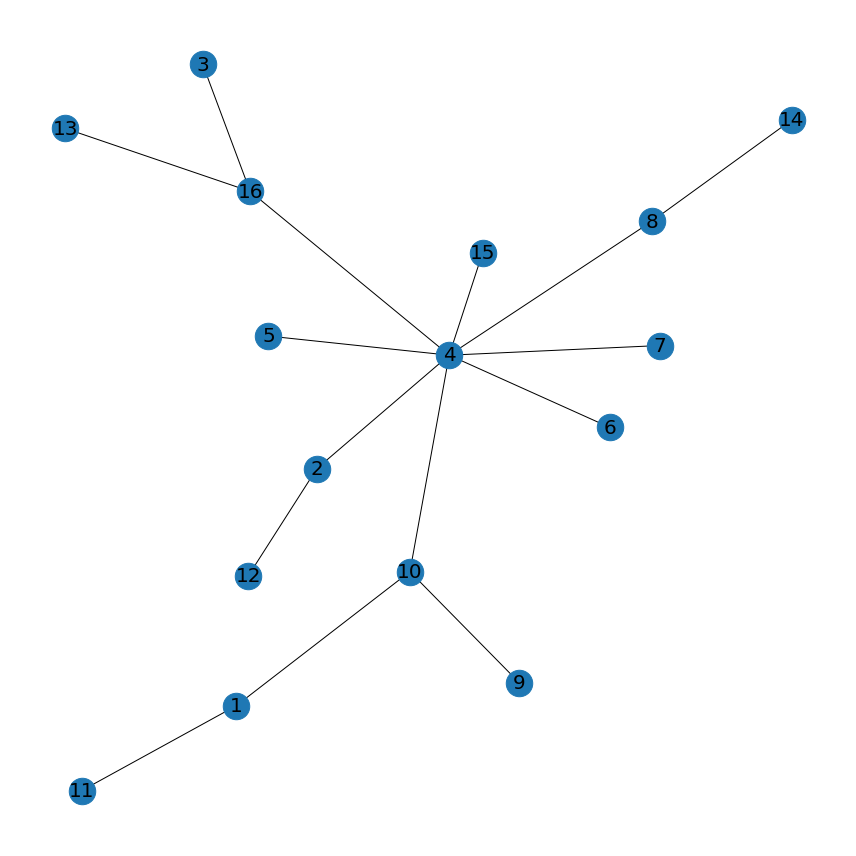

[(1, 4), (4, 16), (4, 15), (4, 8), (4, 9), (4, 7), (4, 14), (15, 12), (9, 11), (7, 13), (4, 2), (4, 6), (15, 10), (16, 3), (8, 5)]


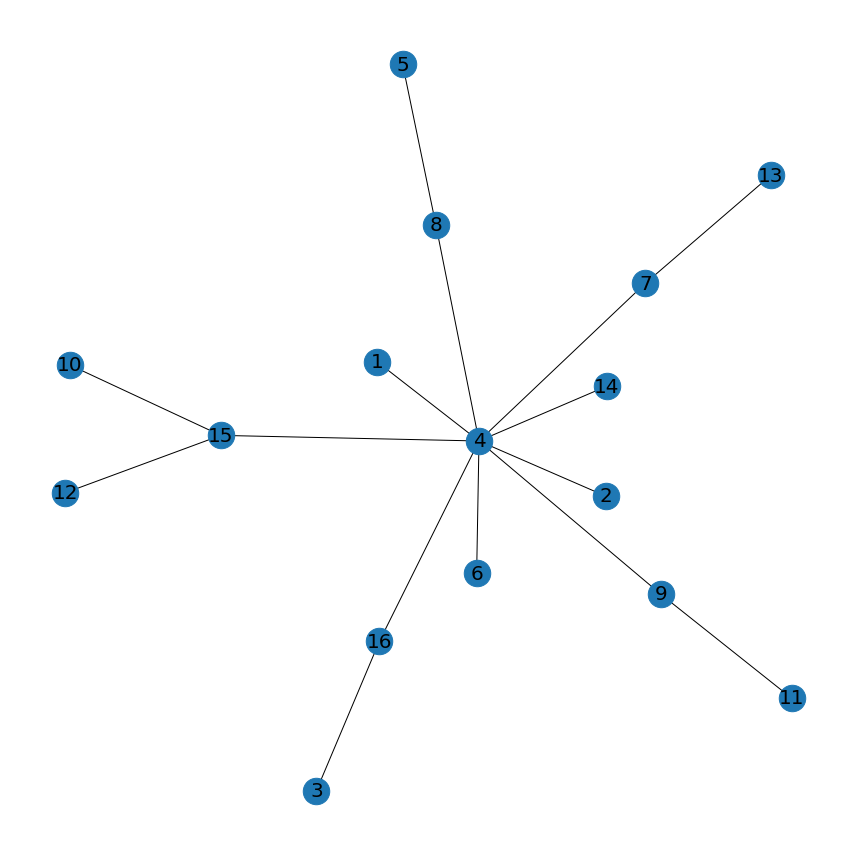

[(1, 4), (4, 12), (4, 9), (4, 16), (4, 10), (10, 7), (1, 11), (12, 5), (9, 14), (16, 2), (4, 15), (14, 8), (4, 6), (12, 13), (16, 3)]


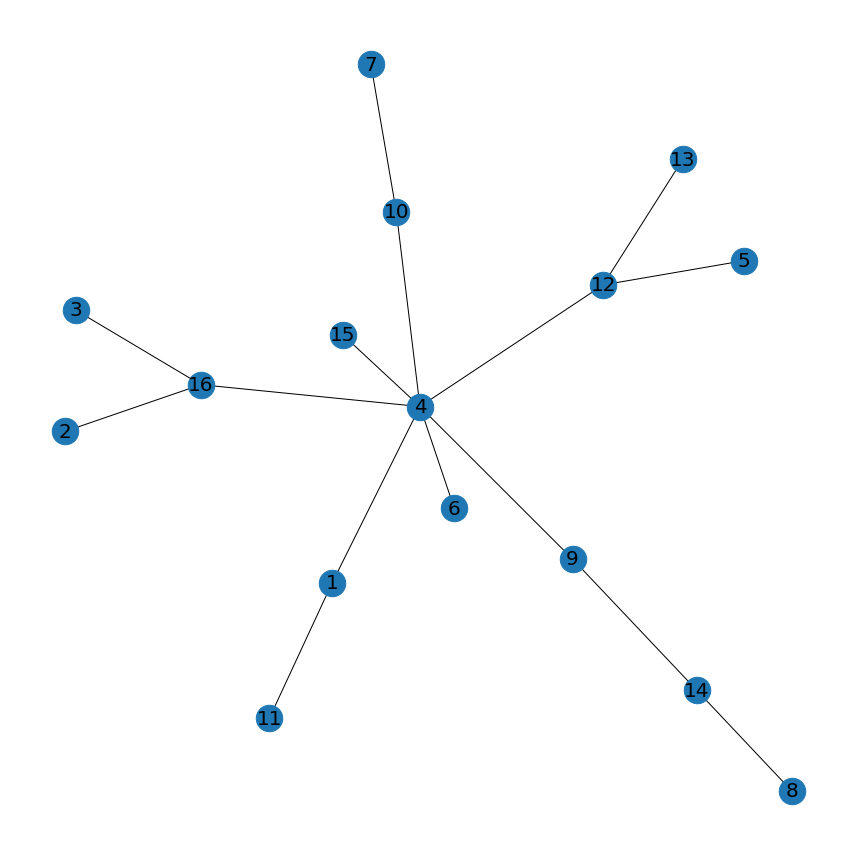

In [14]:
print(hall_of_fame)
print("Time: ", time.process_time() - start)
print("ROOT: ", ROOT)
print("CAPACITY: ", CAPACITY)

for candidate in hall_of_fame.paths:
    print(candidate)
    G = nx.Graph()
    G.add_edges_from(candidate)
    plt.figure(figsize=(12, 12))
    draw_graph(G, TREE_LIKE_LAYOUT)

comp = prim(ADJACENCY_MATRIX)
weight = 0
for edge in comp:
    (col, row) = edge
    weight += ADJACENCY_MATRIX[col - 1][row - 1]

### Future directions
C'è un problema nella visualizzazione dei grafi, in quanto non mi dà la veduta ad albero che solitamente le librerie di
visualizzazione dei grafi forniscono. Vi sono dei bug nella versione Windows di graphviz. 
Altri miglioramenti:
* Ristrutturare tutto il problema per usare anche CPLEX come solver esatto, per confrontare le due soluzioni
* Includere altri problemi o altre varianti